http://conorsvensson.com/2014/11/24/volatility-cones-a-secret-weapon-in-options-trading/

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ib_insync import *
import os
import sys

from optopus.ib_adapter import IBBrokerAdapter
from optopus.optopus import Optopus
from optopus.utils import to_df


%matplotlib inline
plt.style.use('dark_background')

2018-11-18 19:41:45,242 — optopus — INFO — Completed configuring the logger


In [2]:
# port = 7497 TWS paper trading
util.startLoop()
opt = Optopus(IBBrokerAdapter(IB(), host='127.0.0.1', port=7497, client=6))
opt.start()

2018-11-18 19:42:03,744 — optopus.optopus — INFO — System started


INFO:optopus.optopus:System started


# Market

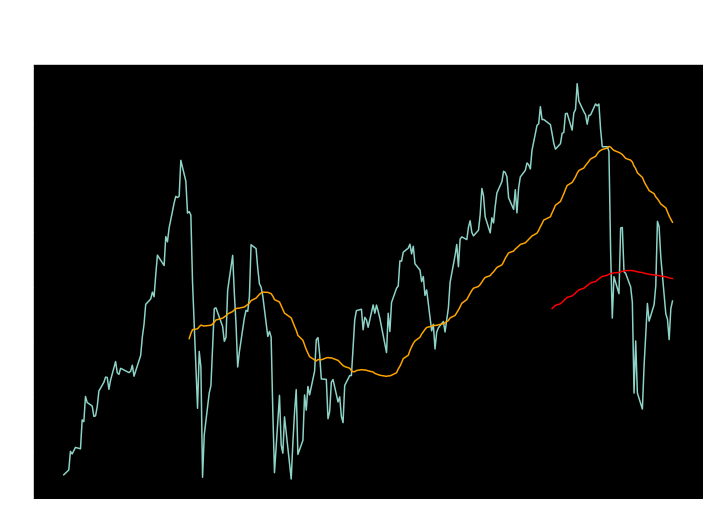

In [3]:
market_code='SPY'
time = opt.series(market_code, "time")
value = opt.series(market_code, "value")
slow_sma = opt.series(market_code, "slow_sma")
very_slow_sma = opt.series(market_code, "very_slow_sma")

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle(f'MARKET ({market_code}')
ax.plot(time, value)
ax.plot(time, slow_sma, color='orange')
ax.plot(time, very_slow_sma, color='red')

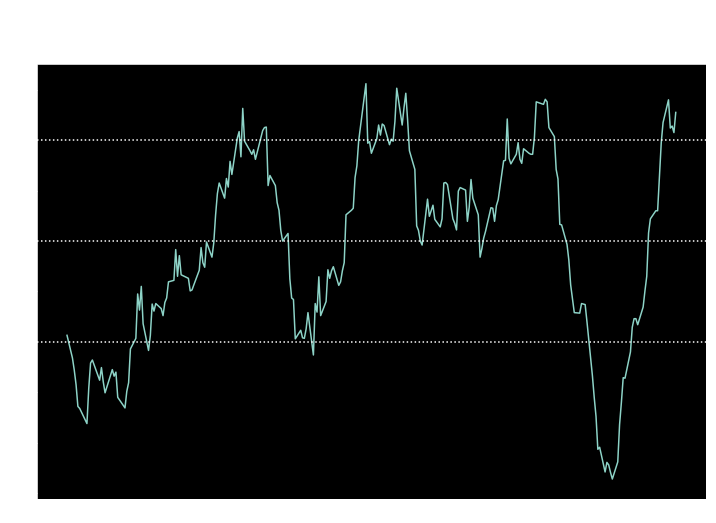

In [4]:
breadth_indicator='TRIN-NYSE'
time = opt.series(breadth_indicator, "time")
fast_sma = opt.series(breadth_indicator, "fast_sma")

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle(f'BREADTH ({breadth_indicator})')
#ax.plot(time, value)
ax.plot(time, fast_sma)
ax.axhline(1.1, linestyle='dotted') # oversold

ax.axhline(1, linestyle='dotted')
ax.axhline(0.9, linestyle='dotted') #overbought


# Underlyings

In [5]:
df = to_df(opt.etfs.values())
df

,code,asset_type,currency,ask,ask_size,bid,bid_size,close,high,last,...,volume,beta,correlation,iv,iv_pct,iv_percentile,iv_rank,price_pct,price_percentile,stdev
0,OIH,ETF,USD,-1.0,0,-1.0,0,19.17,NaN,NaN,...,NaN,1.086827,0.574918,0.359177,0.159535,0.980159,0.330627,0.007303,0.015873,0.013894
1,SPY,ETF,USD,-1.0,0,-1.0,0,273.02,NaN,NaN,...,NaN,1.000000,1.000000,0.160190,-0.033059,0.873016,0.341296,0.002601,0.535714,0.003865
2,XLI,ETF,USD,-1.0,0,-1.0,0,72.01,NaN,NaN,...,NaN,1.016814,0.878841,0.197193,0.009919,0.908730,0.357701,-0.000278,0.158730,0.006767
3,XOP,ETF,USD,-1.0,0,-1.0,0,34.79,NaN,NaN,...,NaN,1.207094,0.616119,0.401641,0.273006,0.984127,0.623748,-0.001150,0.253968,0.015574
4,XLE,ETF,USD,-1.0,0,-1.0,0,66.39,NaN,NaN,...,NaN,0.940746,0.695410,0.244912,0.189148,0.964286,0.533294,0.011899,0.063492,0.007109


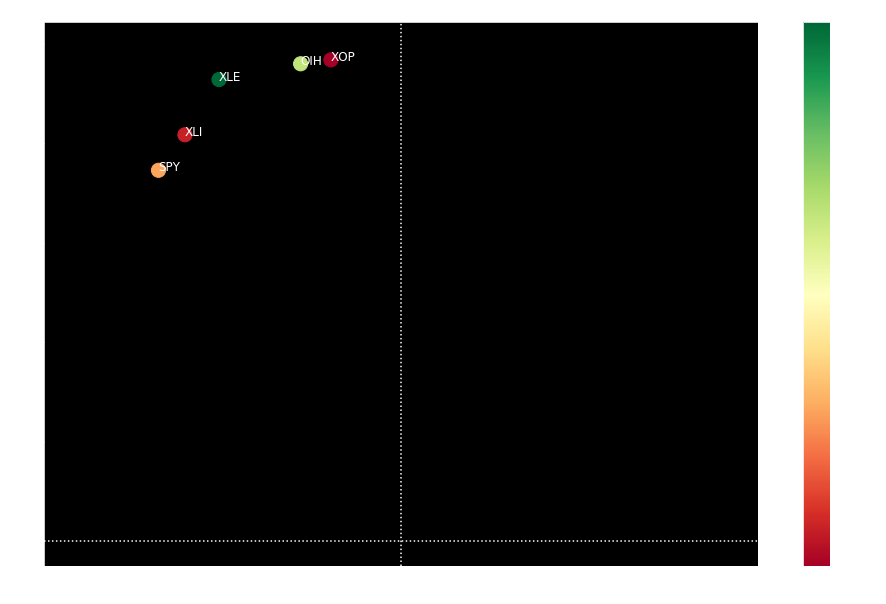

In [6]:
plt.figure(figsize=(16, 10))
sc = plt.scatter(x=df['iv'].values, y=df['iv_percentile'].values, c=df['price_pct'].values, cmap='RdYlGn', s=200)
plt.colorbar(sc).set_label('Return')
plt.title('Implied volatility')
plt.xlabel('Implied Volatility (IV)')
plt.ylabel('Implied Volatility Percentile (IVP)')
plt.xlim(0, 1)
plt.axvline(0.5, linestyle='dotted')
plt.axhline(0.5, linestyle='dotted')
for i, row in df.iterrows():
    #label = row['code'] + '({0:.2f} {1})'.format(row['price_pct'], row['directional_assumption'][0:2])
    label = f'{row["code"]}'
    plt.annotate(label, (row['iv'], row['iv_percentile']), fontsize=12)

In [7]:
df[['code', 'correlation']].sort_values(['correlation'], ascending=False).style.background_gradient(cmap='RdYlGn')

,code,correlation
1,SPY,1
2,XLI,0.878841
4,XLE,0.69541
3,XOP,0.616119
0,OIH,0.574918


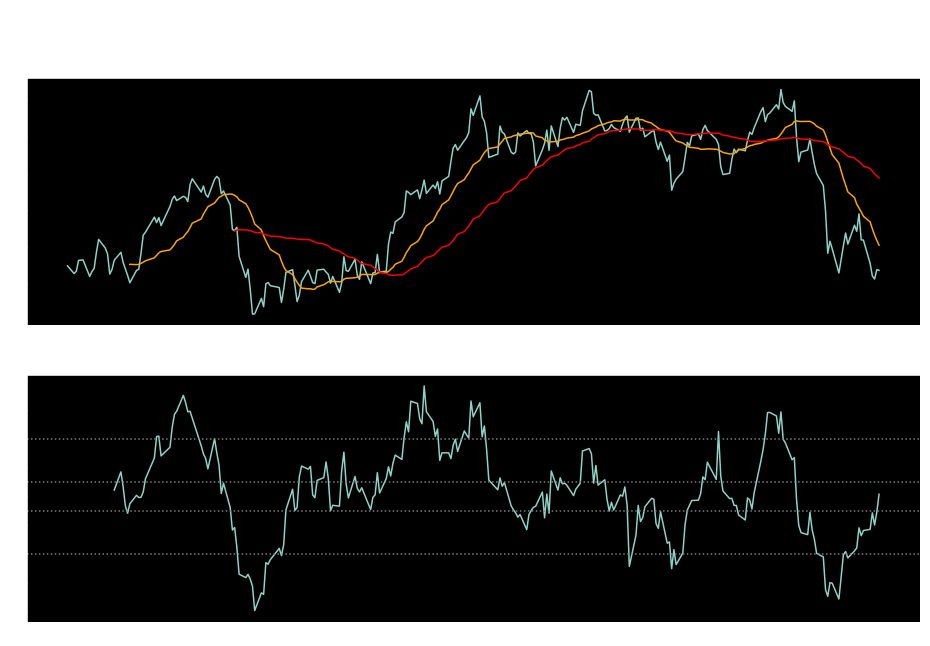

In [32]:
underlying_code='XOP'
time = opt.series(underlying_code, "time")
value = opt.series(underlying_code, "value")
fast_sma = opt.series(underlying_code, "fast_sma")
slow_sma = opt.series(underlying_code, "slow_sma")
rsi = opt.series(underlying_code, "rsi")

fig, ax = plt.subplots(2, sharex=True, figsize=(16, 10))
#fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle(f'Underlying ({underlying_code})')
ax[0].plot(time, value)
ax[0].plot(time, fast_sma, color='orange')
ax[0].plot(time, slow_sma, color='red')

ax[1].plot(time, rsi)
ax[1].axhline(70, linestyle='dotted', color='gray') # overbougth
ax[1].axhline(30, linestyle='dotted', color='gray')
ax[1].axhline(55, linestyle='dotted', color='gray')
ax[1].axhline(45, linestyle='dotted', color='gray') # oversold

In [33]:
candidates = df[(df['iv_percentile'] > 0.8)  & (df['iv'] > 0.2) & (df['price_pct'] < -0.1)]
candidates[['code', 'iv_percentile', 'iv', 'iv_pct', 'price_pct', 'price_percentile', 'correlation', 'market_price']].sort_values(['iv_percentile', 'iv'], ascending=[False, False])

,code,iv_percentile,iv,iv_pct,price_pct,price_percentile,correlation,market_price


In [83]:
direction = opt.series(underlying_code, "direction")

bullish = [v if direction[i] == 'Bullish' else np.nan for i, v in enumerate(value)]
bearish = [v if direction[i] == 'Bearish' else np.nan for i, v in enumerate(value)]


fast_sma_speed = opt.series(underlying_code, "fast_sma_speed")
fast_sma_speed_diff = opt.series(underlying_code, "fast_sma_speed_diff")

up_threshold = 0.0040
low_threshold = -0.0040

up_rsi = 60
low_rsi = 40

bullish = [v if fast_sma_speed_diff[i] > up_threshold else np.nan for i, v in enumerate(value)]
neutral = [v if fast_sma_speed_diff[i] < up_threshold and  fast_sma_speed_diff[i] > low_threshold else np.nan for i, v in enumerate(value)]
bearish = [v if fast_sma_speed_diff[i] < low_threshold else np.nan for i, v in enumerate(value)]

bullish = [v if v > fast_sma[i] and v > slow_sma[i] else np.nan for i, v in enumerate(value)]
neutral = [v if v < fast_sma[i] and v > slow_sma[i] else np.nan for i, v in enumerate(value)]
neutral = [v if fast_sma_speed_diff[i] < up_threshold and  fast_sma_speed_diff[i] > low_threshold else np.nan for i, v in enumerate(value)]
neutral = [v if rsi[i] < up_rsi and rsi[i] > low_rsi else np.nan for i, v in enumerate(value)]
bearish = [v if v < fast_sma[i] and v < slow_sma[i] else np.nan for i, v in enumerate(value)]




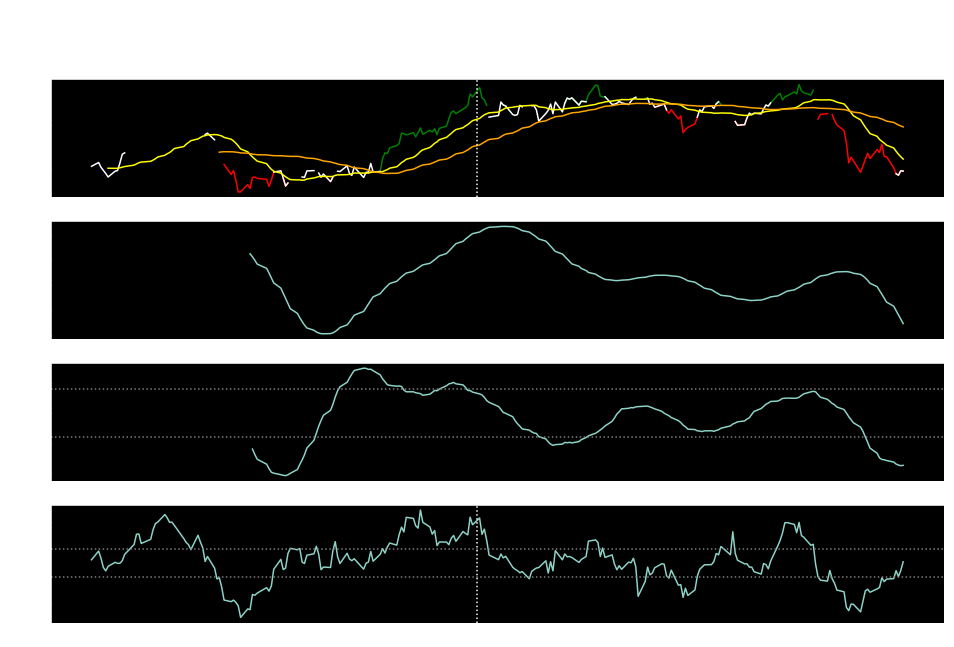

In [84]:
fig, ax = plt.subplots(4, sharex=True, figsize=(16, 10))
fig.suptitle(f'Underlying ({underlying_code})')

ax[0].plot(time, bullish, color='green')
ax[0].plot(time, bearish, color='red')
ax[0].plot(time, neutral, color='white')

ax[0].plot(time, fast_sma, color='yellow')
ax[0].plot(time, slow_sma, color='orange')

ax[0].axvline(datetime.datetime.strptime('20/05/2018', "%d/%m/%Y"), linestyle='dotted')

ax[1].plot(time, fast_sma_speed)


ax[2].plot(time, fast_sma_speed_diff)
ax[2].axhline(up_threshold, linestyle='dotted', color='gray')
ax[2].axhline(low_threshold, linestyle='dotted', color='gray')

ax[3].plot(time, rsi)
ax[3].axhline(up_rsi, linestyle='dotted', color='gray') # overbougth
#ax[3].axhline(45, linestyle='dotted', color='gray')
#ax[3].axhline(55, linestyle='dotted', color='gray')
ax[3].axhline(low_rsi, linestyle='dotted', color='gray') # oversold

ax[3].axvline(datetime.datetime.strptime('20/05/2018', "%d/%m/%Y"), linestyle='dotted')

In [12]:
len(bearish)

252

In [13]:
for i, v in enumerate(direction):
    print(f'{fast_sma[i]:.4f}  {fast_sma_speed[i]:.4f} {fast_sma_speed_diff[i]:.4f}  {v}')

nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
nan  nan nan  nan
68.5825  nan nan  nan
68.6735  nan nan  nan
68.7775  nan nan  nan
68.9230  nan nan  nan
69.1295  nan nan  nan
69.3340  nan nan  nan
69.6045  nan nan  nan
69.8370  nan nan  nan
70.0565  nan nan  nan
70.2145  nan nan  nan
70.4030  nan nan  nan
70.6480  nan nan  nan
70.9305  nan nan  nan
71.2565  nan nan  nan
71.5950  nan nan  nan
71.8925  nan nan  nan
72.1605  nan nan  nan
72.5150  nan nan  nan
72.9115  nan nan  nan
73.2715  nan nan  nan
73.6910  nan nan  nan
74.0525  nan nan  nan
74.4040  nan nan  nan
74.7890  nan nan  nan
75.0935  nan nan  nan
75.3800  nan nan  nan
75.6045  nan nan  nan
75.8620  nan nan  nan
76.0555  nan nan  nan
76.1825  nan nan  na